In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import umap
import umap.plot

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import os
for dirname, _, filenames in os.walk('/dataset'):                    # Change the input path to the folder with dataset 
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ecg-dataset/ecg.csv


> This dataset contains the ECG readings of patients.
> Each row corresponds to a single complete ECG of a patient. Every single ECG is composed of 140 data points(readings).
>  
> 1. Columns 0-139 contain the ECG data point for a particular patient. These are floating point numbers.
> 2. The label which shows whether the ECG is normal or abnormal. It is a categorical variable with value either 0 or 1.

-------------------------------------------------
# Utility Functions

In [2]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)   
     
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('confusion matrix')
    print(confusion)

    # ROC-AUC print 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

------------------------------------------
# Doing Simple EDA

In [3]:
dataframe = pd.read_csv('/kaggle/input/ecg-dataset/ecg.csv', header=None)    # Change the path with the path for dataset 
raw_data = dataframe.values
dataframe.head().style.set_properties(**{'background-color': 'black',
                           'color': 'white',
                           'border-color': 'white'})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,-0.493223,-0.463052,-0.301644,-0.232734,-0.125055,-0.153943,-0.024357,-0.065609,0.034999,0.061935,0.071195,0.123925,0.103124,0.225228,0.128683,0.302483,0.257276,0.196352,0.179383,0.244729,0.341217,0.328204,0.406042,0.446605,0.424068,0.481512,0.477844,0.624083,0.574585,0.598013,0.564592,0.607979,0.620635,0.656253,0.684748,0.694273,0.665584,0.575796,0.638135,0.614917,0.569083,0.468576,0.442818,0.468274,0.432493,0.407958,0.418623,0.362531,0.410959,0.471666,0.372167,0.337875,0.221405,0.273997,0.298664,0.263564,0.342564,0.419505,0.586607,0.860624,1.173345,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.000000
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,-0.206160,-0.224480,-0.048684,-0.019621,0.094805,0.116786,0.185186,0.230526,0.138027,0.244426,0.271695,0.259003,0.269202,0.127065,0.202073,0.255983,0.153115,0.210216,0.191082,0.190927,0.210510,0.207108,0.204888,0.200865,0.346920,0.348002,0.254537,0.331975,0.356690,0.349930,0.430380,0.467502,0.486063,0.403188,0.478956,0.397392,0.464120,0.451795,0.361361,0.379831,0.342785,0.399107,0.387508,0.255703,0.284034,0.284993,0.250108,0.173036,0.149423,0.141685,0.222261,0.172847,0.150779,0.176566,0.280942,0.489939,0.660889,0.893193,1.026997,1.202394,1.557410,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.000000
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,-0.438023,-0.436248,-0.400114,-0.134987,-0.239347,-0.120244,-0.001971,0.285000,0.315646,0.107364,0.109521,0.158078,0.291898,0.261294,0.188407,0.140651,0.263365,0.287207,0.314317,0.177942,0.138290,0.321069,0.458168,0.251916,0.261353,0.277488,0.298793,0.459075,0.419147,0.520509,0.537761,0.603211,0.475634,0.521693,0.735248,0.729541,0.718523,0.498433,0.545441,0.604827,0.521296,0.394381,0.405020,0.597563,0.531130,0.377651,0.467701,0.457569,0.341116,0.407913,0.459127,0.403937,0.298191,0.46110

## Checking Target Imbalance

In [4]:
colors = ['gold', 'mediumturquoise']
labels = ['Normal','Abnormal']
values = dataframe[140].value_counts()/dataframe[140].shape[0]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='white', width=0.1)))
fig.update_layout(
    title_text="ECG dataset",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="black",
    plot_bgcolor='black',
    font_color="white",
)
fig.show()

**OK! Target distribution is balanced.**

----------------------------------------------------
# Splitting Dataset

In [5]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

-----------------------------------------------------------------------
# Preprocessing

In [6]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Train the autoencoder using only the normal rhythm labeled 1 on this dataset. Separates normal and abnormal rhythms.

In [7]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

print("the length of train :",len(train_labels))
print("the length of test :",len(test_labels))

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

the length of train : 3998
the length of test : 1000


Plot the normal ECG.

Text(0.5, 1.0, 'A Normal ECG')

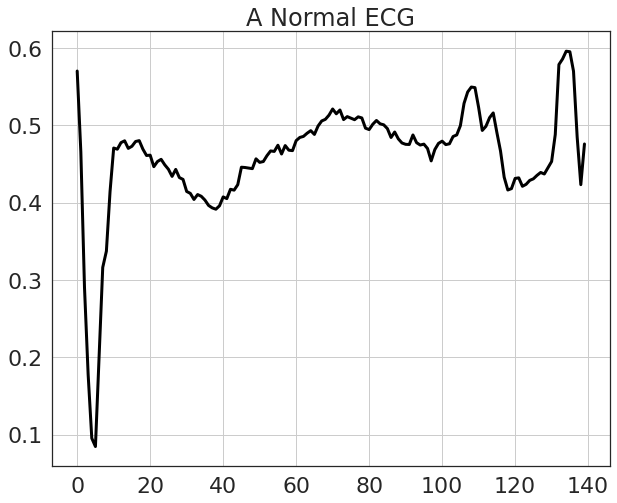

In [8]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.grid()
plt.plot(np.arange(140), normal_train_data[0],color='black',linewidth=3.0)
plt.title("A Normal ECG")

Plot the abnormal ECG.

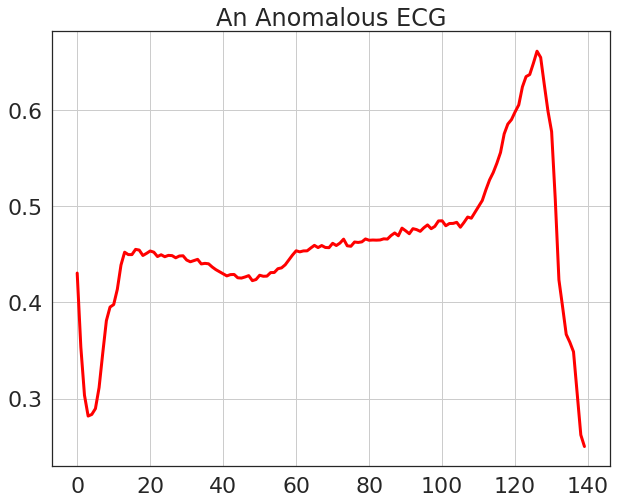

In [9]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0],color='red',linewidth=3.0)
plt.title("An Anomalous ECG")
plt.show()

-----------------------------------
# Modeling

In [10]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [11]:
autoencoder.compile(optimizer='adam', loss='mae')

-----------------------------
# Training
The autoencoder is trained using only regular ECGs, but evaluated using the full test set.

In [12]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 2s 246ms/step - loss: 0.0580 - val_loss: 0.0531
Epoch 2/20
5/5 [==============================] - 0s 27ms/step - loss: 0.0557 - val_loss: 0.0517
Epoch 3/20
5/5 [==============================] - 0s 27ms/step - loss: 0.0523 - val_loss: 0.0496
Epoch 4/20
5/5 [==============================] - 0s 27ms/step - loss: 0.0479 - val_loss: 0.0474
Epoch 5/20
5/5 [==============================] - 0s 27ms/step - loss: 0.0433 - val_loss: 0.0447
Epoch 6/20
5/5 [==============================] - 0s 26ms/step - loss: 0.0390 - val_loss: 0.0426
Epoch 7/20
5/5 [==============================] - 0s 27ms/step - loss: 0.0354 - val_loss: 0.0410
Epoch 8/20
5/5 [==============================] - 0s 26ms/step - loss: 0.0324 - val_loss: 0.0396
Epoch 9/20
5/5 [==============================] - 0s 27ms/step - loss: 0.0299 - val_loss: 0.0387
Epoch 10/20
5/5 [==============================] - 0s 27ms/step - loss: 0.0277 - val_loss: 0.0379
Epoch 11/20
5/5 [===========

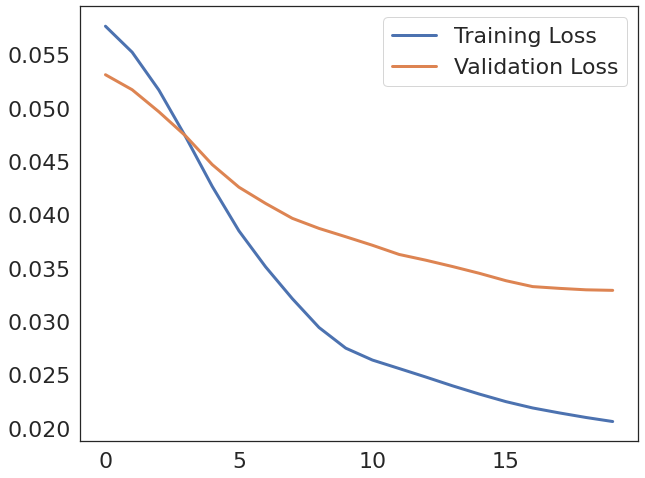

In [13]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(history.history["loss"], label="Training Loss",linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.legend()

If the reconstruction error is greater than one standard deviation from the normal training example, classify the ECG as abnormal. First, let's plot the normal ECG of the training set, the reconstruction after being encoded and decoded by the autoencoder, and the reconstruction error.

---------------------------------------------
# Testing using normal data

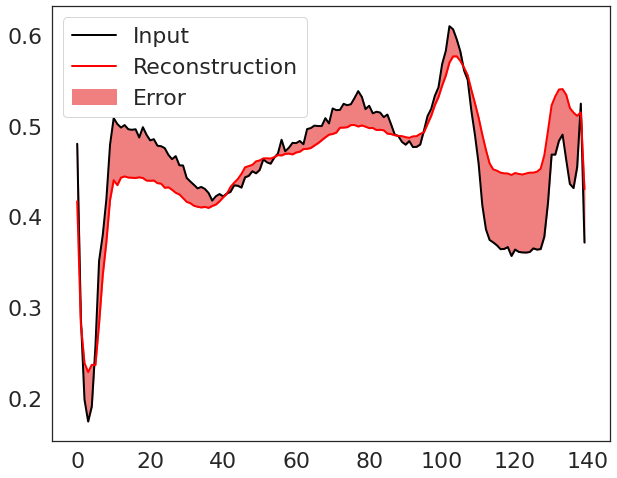

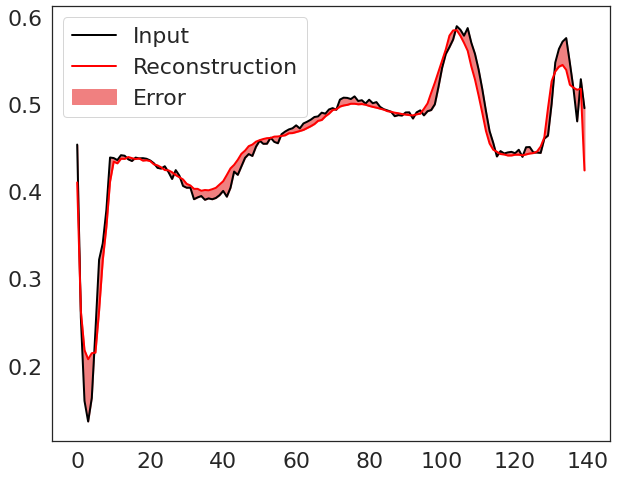

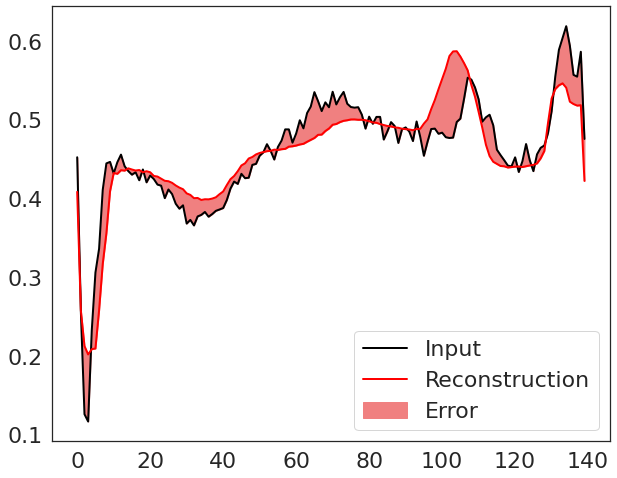

In [14]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

for i in range(0,3):
    plt.figure(figsize=(10,8))
    sns.set(font_scale = 2)
    sns.set_style("white")
    plt.plot(normal_test_data[i], 'black',linewidth=2)
    plt.plot(decoded_imgs[i], 'red',linewidth=2)
    plt.fill_between(np.arange(140), decoded_imgs[i], normal_test_data[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()

In [15]:
encoded_imgs_normal = pd.DataFrame(encoded_imgs)
encoded_imgs_normal['label'] = 1

-------------------------------------------
# Testing using abnormal data

Create a similar plot, this time from abnormal testing examples.

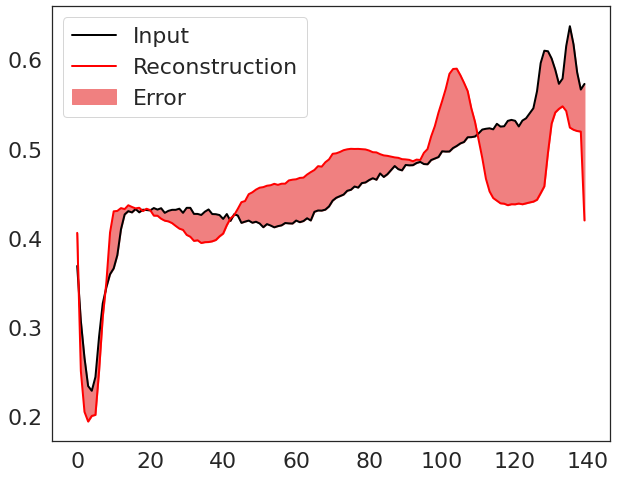

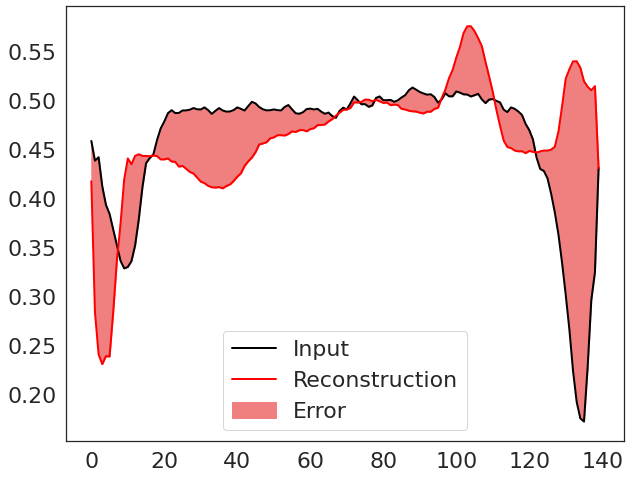

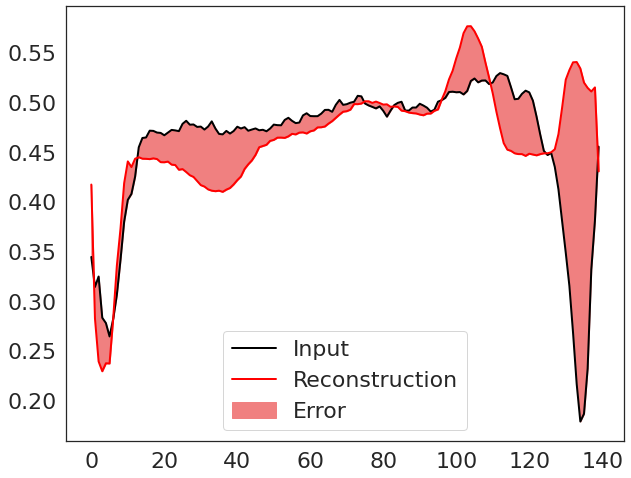

In [16]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

for i in range(0,3):
    plt.figure(figsize=(10,8))
    sns.set(font_scale = 2)
    sns.set_style("white")
    plt.plot(anomalous_test_data[i], 'black',linewidth=2)
    plt.plot(decoded_imgs[i], 'red',linewidth=2)
    plt.fill_between(np.arange(140), decoded_imgs[i], anomalous_test_data[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()

In [17]:
encoded_imgs_abnormal = pd.DataFrame(encoded_imgs)
encoded_imgs_abnormal['label'] = 0

----------------------------------------------------------------------------
# Ploting the Latent Space after Dimension Reduction

In [18]:
all_encoded = pd.concat([encoded_imgs_normal,encoded_imgs_abnormal])

<AxesSubplot:>

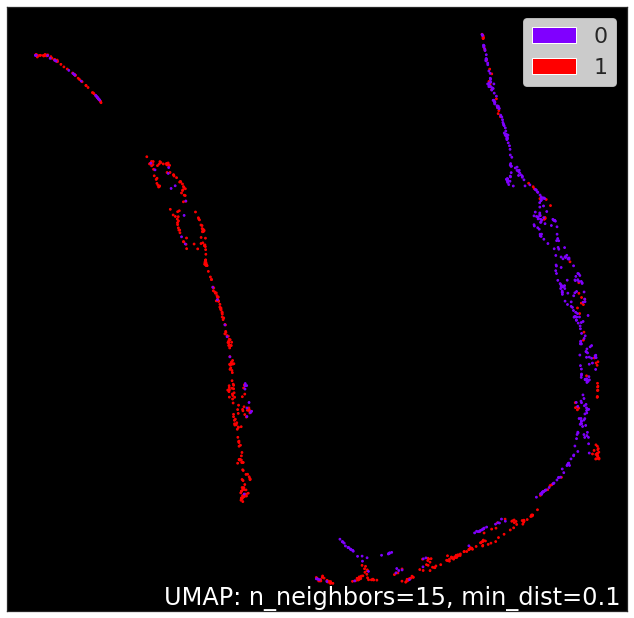

In [19]:
mapper = umap.UMAP().fit(all_encoded.iloc[:,:8])
umap.plot.points(mapper, labels=all_encoded.iloc[:,8], theme='fire')

The figure above shows Dimension Reduction of the latent space for normal and abnormal data. This latent space is a space that has undergone Dimension Reduction by compressing 140-dimensional input into 8-dimensional space.
We compressed this space back into two dimensions to obtain the picture above.

<AxesSubplot:>

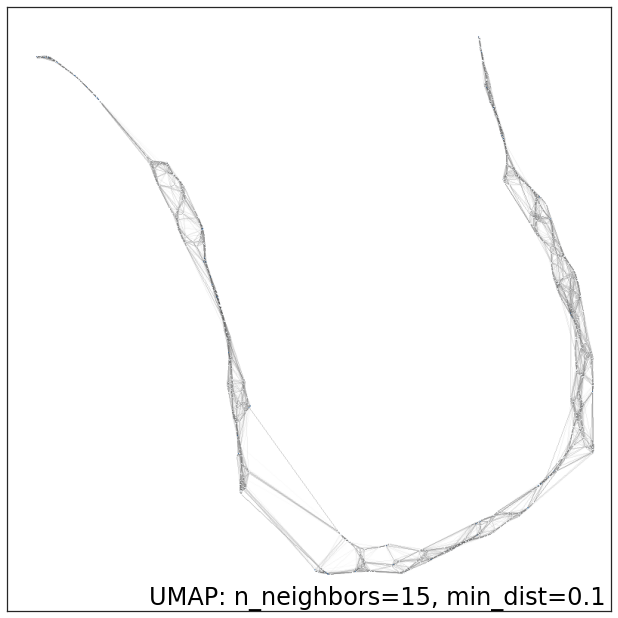

In [20]:
umap.plot.connectivity(mapper, show_points=True)

# Detecting Anomaly

Anomalies are detected by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, we compute the mean error for normal examples in the training set, and then classify future examples as abnormal if the reconstruction error is greater than the standard deviation of the training set.

Plot the reconstruction error for normal ECGs in the training set.

In [21]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

In [22]:
np.mean(train_loss)

0.020386657

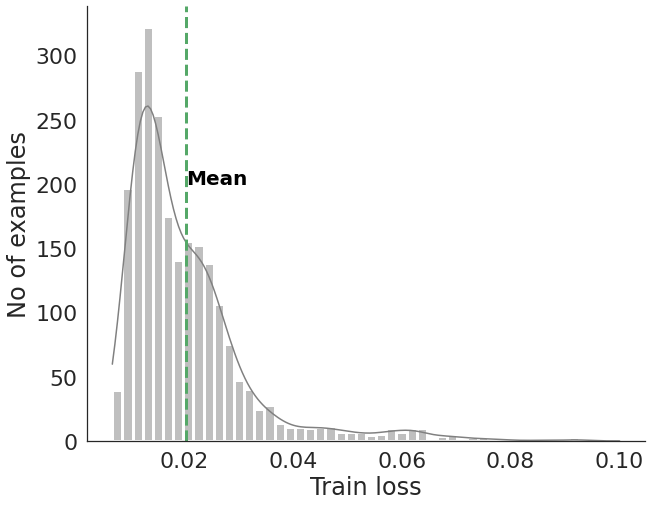

In [23]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Mean", horizontalalignment='left', 
         size='small', color='black', weight='semibold')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()

Let's choose a threshold with a standard deviation higher than the mean.

In [24]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.0322713


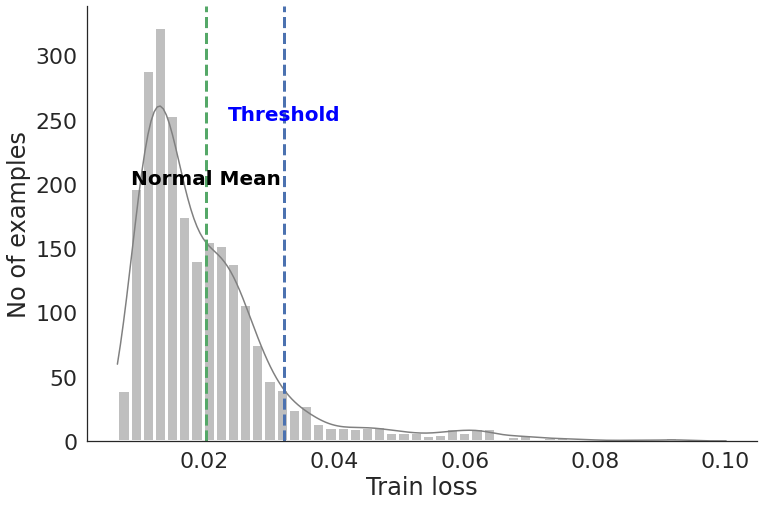

In [25]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()

**Examining reconstruction errors for unusual examples in the test set reveals that most of them have reconstruction errors greater than the threshold(blue-dotted line=0.033).**

In [26]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

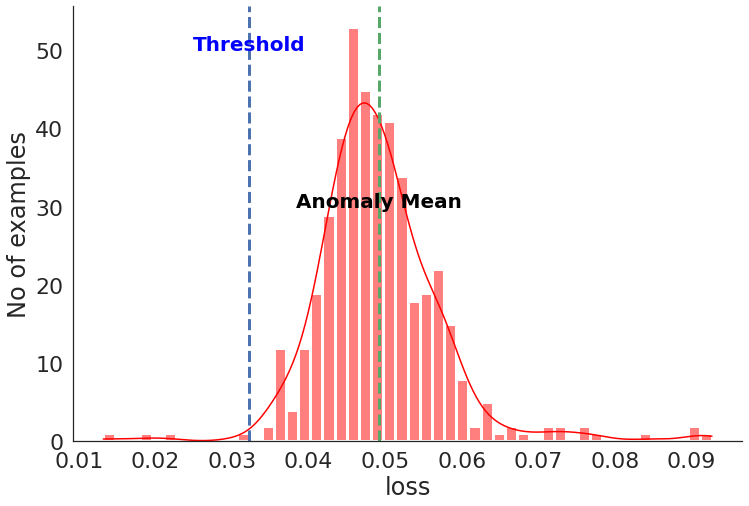

In [27]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 30, "Anomaly Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.text(threshold, 50, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

If the reconstruction error is greater than the threshold(blue-dotted line), classify the ECG as abnormal.

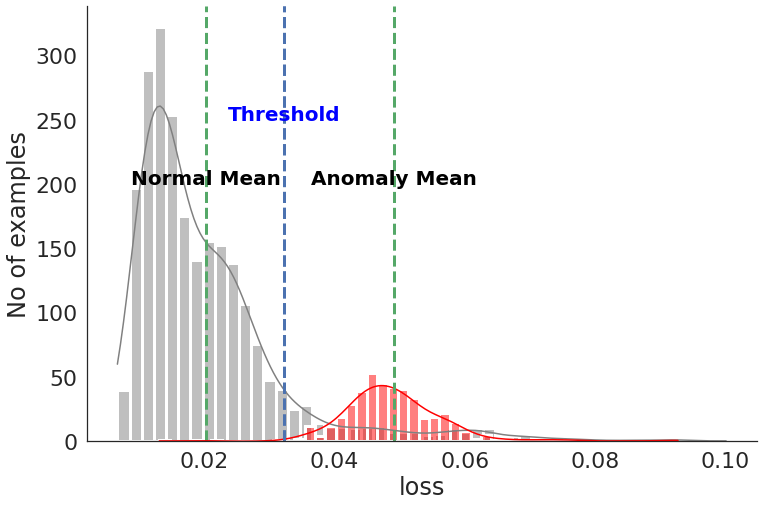

In [28]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')

sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 200, "Anomaly Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

Looking at the picture above, it seems that the threshold was set by considering the Normal and Anomaly distributions well. In particular, it seems that recall is more important than precision for abnomaly detection. In actual application, it may be necessary to consider fine-tuning the threshold.

---------------------------------------------------------------
# Predicting

In [29]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [30]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571


confusion matrix
[[436   4]
 [ 52 508]]
accuracy: 0.9440, precision: 0.9922, recall: 0.9071,    F1: 0.9478, AUC:0.9490


<AxesSubplot:>

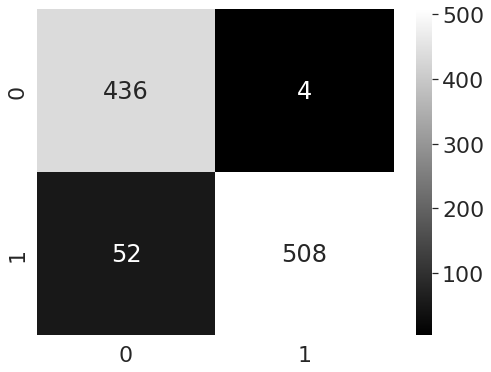

In [31]:
confusion_matrix = get_clf_eval(test_labels,preds,preds)
plt.figure(figsize=(8,6))
sns.set(font_scale = 2)
sns.set_style("white")
sns.heatmap(confusion_matrix, cmap = 'gist_yarg_r',annot = True, fmt='d')